# **CEM & CBM: Практика**

Привет, друзья!
Практика по CBM и CEM будет направлена на понимание теории моделей. В течение практики, мы будем опираться на статью [Concept Embedding Models:
Beyond the Accuracy-Explainability Trade-Off](https://arxiv.org/pdf/2209.09056) и примеры, приложенные в документации библиотеки [pyTorch explain](https://pytorch-explain.readthedocs.io/en/latest/index.html#).

В течение практики, вы:

*   Изучите возможности библиотеки pyTorch explain
*   Рассмотрите и реализуете CBM и CEM модели
*   С помощью построенных моделей решите тригонометрическую и XOR задачи

Приятного кодинга!

![Bootle](https://ucarecdn.com/ddf09dc0-e603-4943-b756-77ba9204f84d/)

## PyTorch, Explain!

PyTorch, Explain! — это библиотека для расширения возможностей PyTorch с целью разработки объяснимых моделей глубокого обучения. Библиотека содержит:

- Специфические функции потерь, метрики и слои, для внедрения концептов в модель
- Обертки для интерпретации моделей, построенных на основе концепций
- Датасеты (бенчмарки) для оценки concept-based моделей

Градиентных и других классических методов интерпретации библиотека не содержит, поэтому может быть полезна только в сценарии разработки concept-based сетей (Deep Concept Reasoners, CEM, CBM и Logic Explained Nets). В практике мы будем работать с CBM и CEM.

In [ ]:
!pip install torch-explain -q # Установим pytorch-explain

## Наборы данных.

Разметка концептов, как мы с вами обсудили в модуле — времязатратно. Поэтому для оценки моделей мы будем использовать уже заранее подготовленые бенчмарки XOR и Dot.


**XOR data**

Для усложнения классической задачи, датасет XOR в качестве входных признаков использует непрерывную пару значений $(x_1, x_2)$ из отрезка $[0, 1]$. Концептами в задаче являются булевы векторы, сформированные по правилу $(Bool(c_1 > 0.5), Bool(c_2 > 0.5))$


**Dot data**

Набор данных, который создается следующим образом:
1. Берется 4 вектора  $v_1, v_2, w_1, w_2 ∈ R^2$, причем w_1 = (1, 1), w_2 = (-1, -1)
2. Для них строится объект $x = (x_1, x_2, x_3, x_4): x_1, x_2 =  v_1 + v_2, x_3, x_4 = v_1 - v_2$
2. На основе взятых векторов генерируются две концептуальные аннотации, указывающие смотрят ли $v_i, w_i$ в одном направлении.
3. Целевая переменная $y$ же представляет собой результат ответа на вопрос, смотрят ли $v_1$, $v_2$ (практически) в одном направлении



**Материалы, если вам понравятся модели:**

- [Репозиторий](https://github.com/yewsiang/ConceptBottleneck) с кодом из оригинальной статьи [Concept Bottleneck Models](https://arxiv.org/pdf/2007.04612)
- [Реализация](https://github.com/mateoespinosa/cem/tree/main) CEM на основе статей архитектуры на NeurIPS 2022
- Для более глубокой [практики](https://github.com/Trustworthy-ML-Lab/Label-free-CBM/tree/main) с CBM, на основе статьи [Label-free Concept Bottleneck Models](https://openreview.net/pdf?id=FlCg47MNvBA)

Импортируем необходимые библиотеки для работы.

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


import random
import numpy as np

import torch_explain as te
from torch_explain import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Сразу же загрузим первый датасет для практики
x_xor, c_xor, y_xor = datasets.xor(500)
x_xor_train, x_xor_test, c_xor_train, c_xor_test, y_xor_train, y_xor_test = train_test_split(x_xor, c_xor, y_xor,
                                                                            test_size=0.33,
                                                                            random_state=42)

**Concept Bottleneck Models**

Вспомним, как выглядит CBM:

![CBM_model](https://ucarecdn.com/96ae12f2-d0db-4d7e-851b-7240178c5593/-/crop/2303x803/24,0/-/preview/)


Математически CBM есть комбинация двух функций, $y = f(g(x)),$ где $g(x)$ — функция, ставящая в соответствие каждому входному объекту вектор концептов (`concept_encoder`), $f(g(x))$ —  функция, ставящая в соответствие каждому вектору концептов целевой ответ (`task_predictor`).

Архитектура и `concept_encoder`, и `task_predictor` может быть любой, но в целом — это две обязательные составные части CBM модели.  

**Доопределите модель, верно расставив размерности. Чему равны Task и Concept accuracy?**

In [ ]:
#Зафиксируем все сиды для возспроизводимости результатов

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)


class Concept_Bottleneck_Model(nn.Module): # Инициализация CBM модели

  def __init__(self, input_size, hidden_size, concept_size, len_out):
    super(Concept_Bottleneck_Model, self).__init__()

    # Часть 1: concept encoder
    self.concept_encoder = torch.nn.Sequential(torch.nn.Linear(input_size, hidden_size), # Линейный слой
                                               torch.nn.LeakyReLU(), # Функция активации с
                                               torch.nn.Linear("", 8), # ПОСТАВЬТЕ РАЗМЕРНОСТЬ ЗДЕСЬ
                                               torch.nn.LeakyReLU(),
                                               torch.nn.Linear("", concept_size), # ПОСТАВЬТЕ РАЗМЕРНОСТЬ ЗДЕСЬ
                                               torch.nn.Sigmoid())
    # Часть 2: task predictor
    self.task_predictor = torch.nn.Sequential(torch.nn.Linear("", 4), # ПОСТАВЬТЕ РАЗМЕРНОСТЬ ЗДЕСЬ
                                               torch.nn.LeakyReLU(),
                                               torch.nn.Linear(4, len_out))

  def forward(self, input):

    c_pred = self.concept_encoder(input)
    y_pred = self.task_predictor(c_pred)

    return c_pred, y_pred

Теперь обучим модель на импортированном наборе данных.

In [ ]:
# Определим инициализированную модель
XOR_CBM = Concept_Bottleneck_Model(x_xor.shape[1], 16, c_xor.shape[1], 1)

# Определим функции потерь для концептов и классов, а также оптимизатор

optimizer = torch.optim.AdamW(XOR_CBM.parameters(), lr=0.01)
loss_form_c = torch.nn.BCELoss()
loss_form_y = torch.nn.BCEWithLogitsLoss()

# переходим в train mode
XOR_CBM.train()

for epoch in range(2001):
    optimizer.zero_grad()

    # прогнозируем концепты и задачу
    c_xor_pred = XOR_CBM.concept_encoder(x_xor_train)
    y_xor_pred = XOR_CBM.task_predictor(c_xor_pred)

    # обновляем функции потерь (не меняйте коэффициент)
    concept_loss = loss_form_c(c_xor_pred, c_xor_train)
    task_loss = loss_form_y(y_xor_pred, y_xor_train)
    loss = concept_loss + 0.2*task_loss

    loss.backward()
    optimizer.step()

И решим задачу! Не забудьте занести ответы на степик.

In [ ]:
c_xor_pred = XOR_CBM.concept_encoder(x_xor_test) # спрогнозируем концепты
y_xor_pred = XOR_CBM.task_predictor(c_xor_pred) # спрогнозируем решение задачи

concept_xor_accuracy = accuracy_score(c_xor_test, c_xor_pred > 0.5)
task_xor_accuracy = accuracy_score(y_xor_test, y_xor_pred > 0)

print(f'Concept accuracy: {concept_xor_accuracy}\n Task accuracy: {task_xor_accuracy}')

In [ ]:
# Оценим работу модели на парах концептов (1, 0), (0, 1), (1, 1), (0, 0)

c_different = torch.FloatTensor([0, 1])
print(f"f({c_different}) = {int(XOR_CBM.task_predictor(c_different).item() > 0)}")

c_different2 = torch.FloatTensor([1, 0])
print(f"f({c_different2}) = {int(XOR_CBM.task_predictor(c_different2).item() > 0)}")

c_equal = torch.FloatTensor([1, 1])
print(f"f({c_equal}) = {int(XOR_CBM.task_predictor(c_equal).item() > 0)}")

c_equal0 = torch.FloatTensor([0, 0])
print(f"f({c_equal0}) = {int(XOR_CBM.task_predictor(c_equal0).item() > 0)}")

После обучения работа модели прозрачна, мы понимаем, что она выдает единицу при различных значениях для концептов и 0, если входные концепты различны. Отличная работа!

Кроме того, обратите внимание на процесс обучения — обновление функции ошибки зависит лишь от 0.2 `task_loss`, поэтому большее внимание мы акцентируем на концептах. Что будет, если поменять это местами?

In [ ]:
XOR_CBM = Concept_Bottleneck_Model(x_xor.shape[1], 16, c_xor.shape[1], 1)

optimizer = torch.optim.AdamW(XOR_CBM.parameters(), lr=0.01)
loss_form_c = torch.nn.BCELoss()
loss_form_y = torch.nn.BCEWithLogitsLoss()

XOR_CBM.train()

for epoch in range(2001):
    optimizer.zero_grad()

    # прогнозируем концепты и задачу
    c_xor_pred = XOR_CBM.concept_encoder(x_xor_train)
    y_xor_pred = XOR_CBM.task_predictor(c_xor_pred)

    # обновляем функции потерь (не меняйте коэффициент)
    concept_loss = loss_form_c(c_xor_pred, c_xor_train)
    task_loss = loss_form_y(y_xor_pred, y_xor_train)
    loss = 0.2*concept_loss + task_loss

    loss.backward()
    optimizer.step()

In [ ]:
c_xor_pred = XOR_CBM.concept_encoder(x_xor_test)
y_xor_pred = XOR_CBM.task_predictor(c_xor_pred)

concept_xor_accuracy = accuracy_score(c_xor_test, c_xor_pred > 0.5)
task_xor_accuracy = accuracy_score(y_xor_test, y_xor_pred > 0)

print(f'Concept accuracy: {concept_xor_accuracy}\n Task accuracy: {task_xor_accuracy}')

Точность для задачи и концептов значительно не изменилась. Выглядит, будто нет разницы в коэффициентах при loss (вы убедитесь в этом, если позапускаете процесс обучения с различными комбинациями), но такой факт справедлив только для этой задачи — она простая. Посмотрим на обучение CBM на задаче более сложной — используем dot dataset.

Вы также можете убедиться в этом сами, но если запускать обучение с последовательно разным вкладом `concept` и `task_loss` для набора `dot data`, то точность обеих задач будет меняться от несильных до значимых диапазонов.

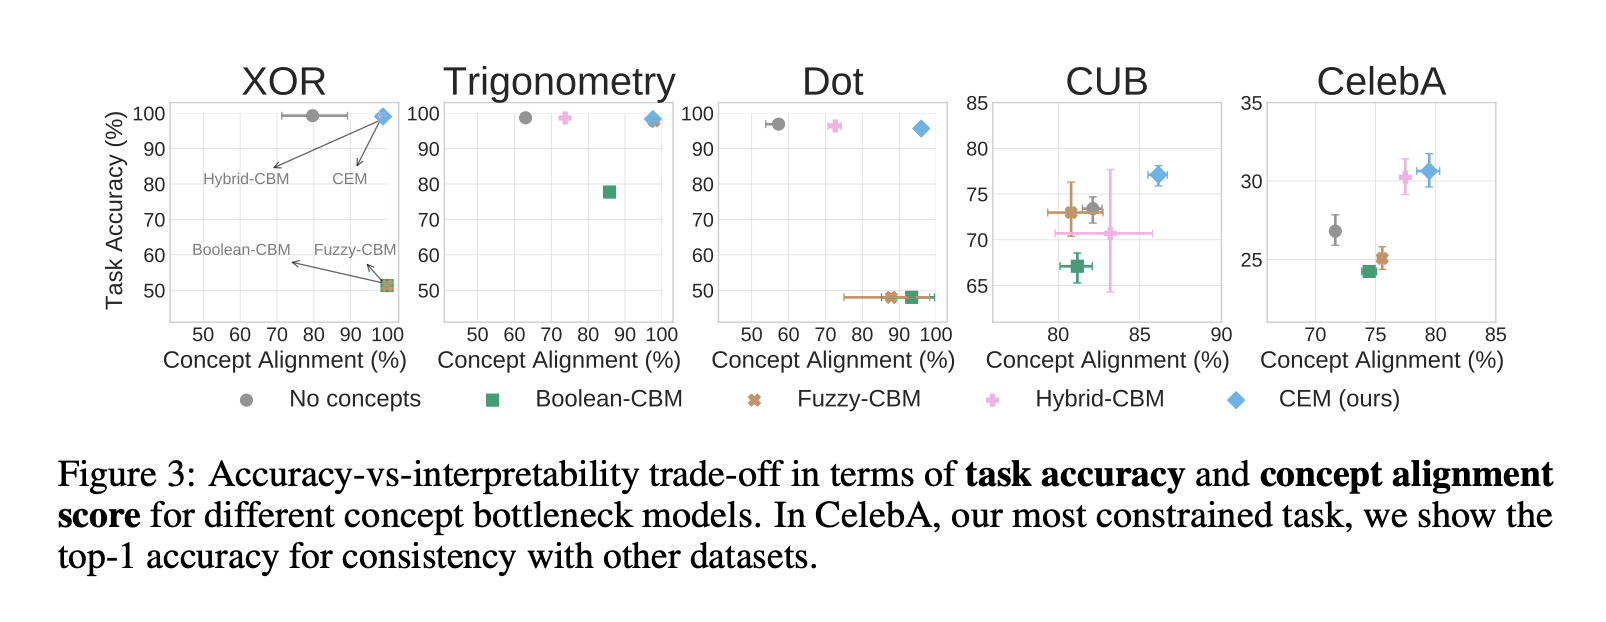
[Источник](https://arxiv.org/pdf/2209.09056)

Это явление называется ***accuracy-explainability trade-off***. Когда исследователь стремится к более высокой точности, объяснения, предоставляемые моделями, имеют тенденцию ухудшаться по качеству и корректности, и наоборот. Переход от Concept Bottleneck Models к Concept Embedding Models частично решает эту проблему.

В следующей части практики вы в этом убедитесь, сравнив производительность CBM и CEM на наборе данных dot самостоятельно.

**Посмотрите на код генерации dot_data на степик. Какие части плоскости разделяют концепты в dot data?**

In [ ]:
#Загрузим набор данных и выделим тренировочную и тестовую выборки

x_dot, c_dot, y_dot = datasets.dot(500)
x_dot_train, x_dot_test, c_dot_train, c_dot_test, y_dot_train, y_dot_test = train_test_split(x_dot, c_dot, y_dot,
                                                                     test_size=0.33, random_state=42)

Обучим модель concept-based модель, на лучшей комбинации concept и task losses. **Выберите её на степик, проверьте свой ответ и обучите модель.**

In [ ]:
DOT_CBM = Concept_Bottleneck_Model(x_dot.shape[1], 16, c_dot.shape[1], 1)

optimizer = torch.optim.AdamW(DOT_CBM.parameters(), lr=0.01)
loss_form_c = torch.nn.BCELoss()
loss_form_y = torch.nn.BCEWithLogitsLoss()

DOT_CBM.train()

for epoch in range(2001):

  optimizer.zero_grad()

  # прогнозируем концепты и задачу
  c_dot_pred = DOT_CBM.concept_encoder(x_dot_train)
  y_dot_pred = DOT_CBM.task_predictor(c_dot_pred)

  # обновляем функции потерь (не меняйте коэффициент)
  concept_loss = loss_form_c(c_dot_pred, c_dot_train)
  task_loss = loss_form_y(y_dot_pred, y_dot_train)
  loss = #ВАШ_КОЭФФ*concept_loss + task_loss

  loss.backward()
  optimizer.step()



In [ ]:
c_dot_pred = DOT_CBM.concept_encoder(x_dot_test)
y_dot_pred = DOT_CBM.task_predictor(c_dot_pred)

concept_dot_accuracy = accuracy_score(c_dot_test, c_dot_pred > 0.5)
task_dot_accuracy = accuracy_score(y_dot_test, y_dot_pred > 0)

print(f'Concept accuracy: {concept_dot_accuracy}\n Task accuracy: {task_dot_accuracy}')

Точность концептов можно назвать неудовлетворительной, хотя задача моделью решается вполне сносно.

## От CBM к CEM
Создадим класс  Concept Embedding Model. Структура этой модели несколько отлична от структуры CBM.

![CBM](https://ucarecdn.com/9626f7a1-c054-4f97-86da-50fb7f61b778/)

**В машинном обучении есть похожие подходы — когда одной моделью мы прогнозируем какую-то переменную в задаче, а потом вызываем получение прогноза при помощи другой — метамодели. Как называются эти подходы?**

С одной стороны, можно зашить эту структуру в модель самостоятельно. С другой, благодаря возможностям библиотеки pytorchExplain! это можно сделать добавив в модель часть `te.nn.ConceptEmbedding(10, concept_size, embedding_size)`

In [ ]:
class Concept_Embedding_Model(nn.Module): #  Создадим класс CEM

  def __init__(self, input_size, hidden_size, concept_size, embedding_size, len_out):
    super(Concept_Embedding_Model, self).__init__()

    # Часть 1 + 2: latent code + Concept Embedding generator
    self.latetnt_code = torch.nn.Sequential(torch.nn.Linear(input_size, hidden_size),
                                               torch.nn.LeakyReLU(),
                                               torch.nn.Linear(hidden_size, 10),
                                               torch.nn.LeakyReLU(),
                                               te.nn.ConceptEmbedding(10, concept_size, embedding_size), # добавляем слой, ответственный за эмбеддинги концептов
                                               )
    # Часть 2: task predictor
    self.task_predictor = torch.nn.Sequential(torch.nn.Linear(concept_size*embedding_size, 5),
                                               torch.nn.LeakyReLU(),
                                               torch.nn.Linear(5, len_out))

  def forward(self, input):

    c_emd, c_pred  = self.latetnt_code(input)
    y_pred = self.task_predictor(c_pred)

    return c_emd, c_pred, y_pred

Обучим нашу CEM и проверим качество.

In [ ]:
CEM = Concept_Embedding_Model(x_dot.shape[1], 16, c_dot.shape[1], 8, 1)

optimizer = torch.optim.AdamW(CEM.parameters(), lr=0.01)
loss_form_c = torch.nn.BCELoss()
loss_form_y = torch.nn.BCEWithLogitsLoss()
CEM.train()
for epoch in range(2001):
    optimizer.zero_grad()

    # прогнозируем эбмдеддинги и метки концептов
    c_emb, c_pred = CEM.latetnt_code(x_dot_train)
    y_pred = CEM.task_predictor(c_emb.reshape(len(c_emb), -1))

    # вычисляем функцию потерь
    concept_loss = loss_form_c(c_pred, c_dot_train)
    task_loss = loss_form_y(y_pred, y_dot_train)
    loss = concept_loss + 0.3*task_loss

    loss.backward()
    optimizer.step()

In [ ]:
# Проверим качество решения задачи

c_dot_emb, c_dot_pred = CEM.latetnt_code.forward(x_dot_test)
y_dot_pred = CEM.task_predictor(c_dot_emb.reshape(len(c_dot_emb), -1))

concept_dot_accuracy = accuracy_score(c_dot_test, c_dot_pred > 0.5)
task_dot_accuracy = accuracy_score(y_dot_test, y_dot_pred > 0)

print(f'Concept accuracy: {concept_dot_accuracy}\n Task accuracy: {task_dot_accuracy}')

Вот так — *одна строка* архитектуры позволила нам повысить и практически сопоставить точности как в решении задачи нахождения концептов, так и в решении целевой задачи!

pytorch_explain! предоставляет ещё много других стратегий реализации более интерпретируемых concept-based моделей. Надеюсь, эта домашка-туториал смогла вас заинтересовать!

**Спасибо за практику и до новых встреч!**

**Примечание:**

Другой способ реализации CEM представлен [здесь](https://github.com/mateoespinosa/cem/tree/main). Однако он на 29.08.2014 не являлся рабочим.